# Example of cross-validation methodology on LIWC

I'm adopting a two-part strategy conditioned by three reflections:

1. I'm not confident that I can apportion *r<sup>2</sup>* well on my own. But the [pingouin linear regression function](https://pingouin-stats.org/generated/pingouin.linear_regression.html) has a sophisticated relative-importance option based on ```relaimpo``` in R. I'd like to use it.

2. Pingouin's function is absolutely glacial with more than about 10 variables. But our "factor/dummy variable" approach to firstpub and birthyear means we will easily have scores of variables.

3. I'm also worried about overfitting, especially to authors.

Putting these three reflections together, I'm thinking the best approach for each dependent variable is:

A) Cross-validate *separate* linear regressions using only birthyear, only firstpub, and only age as a predictive variable. In each case choose the granularity of dummy variables (bins or splines) that optimizes held-out-author accuracy. In each case produce a set of predicted values for the dependent variable that are based only on birthyear, firstpub, or age. We can understand these predictions as "models," of a kind. They describe a relation between the predictive and dependent variables, and do it with a degree of coarseness and degree of uncertainty that are defined by the cross-validation process. The predictions are only as precise as they actually *can* be on held-out authors.

B) Then combine the crossvalidated-predictions-based-on-birthyear, based-on-firstpub, and based-on-age in a pingouin regression and extract variable importance estimates. We'll have only three variables so this is easy for pingouin, and we'll get good estimates of variable importance.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.stats import pearsonr
import random
from sklearn.linear_model import LinearRegression

In [2]:
liwc = pd.read_csv('../liwc/liwc_w_meta.tsv', sep = '\t', low_memory = False)

In [3]:
data = liwc.loc[liwc.us_national & (liwc.firstpub > 1889) & (liwc.firstpub < 1990), : ]

In [6]:
data.head()

,docid,birthyear,firstpub,hathi_author,hathi_title,us_national,authof3ormore,authorage,WC,Analytic,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
1,uc1.32106005212219,1908.0,1947,"Petry, Ann Lane",Country place,True,True,39.0,47351,31.73,...,1.90,0.66,0.27,0.39,0.81,0.13,0.23,0.23,0.23,0.03
2,mdp.39015063937406,1858.0,1906,"Moore, John Trotwood",The bishop of Cottontown : a story of the sout...,True,True,48.0,89468,39.84,...,0.77,0.61,1.41,0.75,1.24,0.11,0.59,0.16,0.39,0.02
4,uc1.$b100730,1889.0,1938,"Frank, Waldo David",The bridegroom cometh,True,True,49.0,130016,32.17,...,1.52,0.90,0.70,0.47,0.79,0.10,0.17,0.24,0.31,0.00
6,mdp.39015003629410,1937.0,1969,"Zelazny, Roger",Damnation alley,True,True,32.0,29342,32.72,...,0.52,0.31,0.61,0.52,1.26,0.58,0.12,0.34,0.24,0.02
7,nyp.33433076053804,1876.0,1921,"Rinehart, Mary Roberts",More Tish,True,True,45.0,32705,26.09,...,0.76,0.50,0.35,0.29,0.78,0.11,0.04,0.10,0.53,0.00


## Overall strategy re: binning continuous variables

We're going to be creating bins or splines that divide our predictive variables into segments. In the most extreme case, we could have dummy variables for every possible value: ```birthyear1870, birthyear1871,``` and so on. But we will also be trying larger bins. 

In dividing up the range of these variables, we confront the problem that two of the variables are long-tailed.

It's not a huge problem with ```firstpub,``` which is not uniform, but also not long-tailed.

<AxesSubplot:xlabel='firstpub', ylabel='Count'>

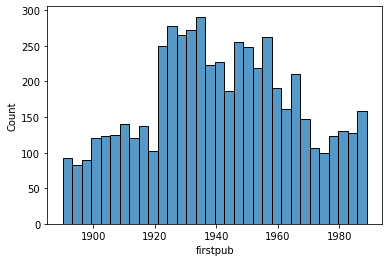

In [8]:
sns.histplot(data.firstpub, bins = 32)

But ```age``` and ```birthyear``` do have relatively significant tails. Bins sized to an equal number of years could easily overfit authors over the age of 75, or ones born before 1850.

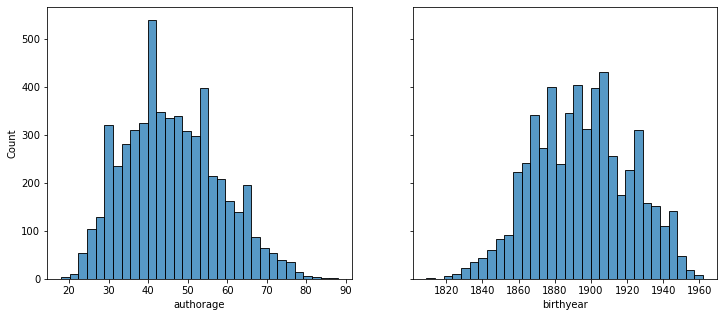

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12,5))
sns.histplot(data.authorage, bins = 32, ax = ax1)
sns.histplot(data.birthyear, bins = 32, ax = ax2)
plt.show()

In [13]:
authorsperspan = dict()
predictornames = ['birthyear', 'firstpub', 'authorage']
for pn in predictornames:
    print(pn)
    authorsperspan[pn] = dict()
    for span in range(1, 61):
        mincol = int(min(data.loc[ : , pn]))
        maxcol = int(max(data.loc[ : , pn]))
        authcts = []
        for t in range(mincol, maxcol):
            authct = len(set(data.loc[(data[pn] >= t) & (data[pn] < t + span), 'hathi_author'].tolist()))
            authcts.append(authct)
        authorsperspan[pn][span] = np.mean(authcts)

birthyear
firstpub
authorage


## The binning function

Here's the function we use to divide a variable range into bins or splines.

In [29]:
def divide_range(data, colname, granularity, degree, minauthor_rule = True):
    
    '''
    Makes a dummy dataframe by dividing variable 'colname' with a given
    'granularity,' except that we also follow a rule that no dummy variable
    can cover fewer than ten authors, or less than half the average number
    for that span across the timeline.
    
    So the granularity will stretch in sparse parts of the timeline.
    
    There is also a parameter "degree" that allows us to specify whether
    we want each bin to behave simply as a step function in regression,
    or whether we want them to behave as crude linear (or quadratic) splines.
    
    degree 0 = step function
    degree 1 = linear interpolation
    '''
    
    global authorsperspan
    
    mincol = int(min(data.loc[ : , colname]))
    maxcol = int(max(data.loc[ : , colname])) + 1       # we set this one higher than the max so
                                                        # that we can treat bins as floor-inclusive
                                                        # and ceiling-exclusive, like Python ranges
    
    floor = mincol
    floors = []
    
    if minauthor_rule:
        minauthct = int(authorsperspan[colname][granularity] / 3)  # this guarantees minimum author count
        if minauthct < 10:                                         # it cannot in any case be less than 10
            minauthct = 10
    else:
        minauthct = 1
    
    while floor < maxcol:
        nextfloor = floor + granularity
        authcount = 0
        while authcount < minauthct:
            authcount = len(set(data.loc[(data[colname] >= floor) & (data[colname] < nextfloor), 'hathi_author'].tolist()))
            if authcount < minauthct:
                nextfloor += 1
            if nextfloor > maxcol:
                authcount = minauthct
            remainingcount = len(set(data.loc[data[colname] >= nextfloor, 'hathi_author'].tolist()))
            if remainingcount < minauthct:
                nextfloor = maxcol
        floors.append(floor)
        floor = nextfloor
    
    if floors[-1] != maxcol:
        floors.append(maxcol)

    newdict = dict()
    newdict['author'] = []
    newdict['docid'] = []
    columns = ['docid', 'author']
    for f in floors[0 : ]:
        
        newdict['l' + str(f)] = []
        columns.append('l' + str(f))  # the linear variable for this bin
               
    for idx, row in data.iterrows():
        value = row[colname]
        for idx, ceiling in enumerate(floors[1: ]):
            if value < ceiling:
                thisfloor = floors[idx]
                
                if degree == 0:
                    floorprox = 1
                    ceilprox = 0
                    
                    break
                    
                else:
                    
                    floorprox = ceiling - value 
                    ceilprox = value - thisfloor
                    
                    total = floorprox + ceilprox  
                    floorprox = floorprox / total
                    ceilprox = ceilprox / total

                    break
    
        for f in floors[0 : ]:
            if thisfloor == f:   
                newdict['l' + str(f)].append(floorprox)
                    
            elif ceiling == f:
                newdict['l' + str(f)].append(ceilprox)     # this will be zero if degree == 0
                    
            else:
                newdict['l' + str(f)].append(0)
        
        newdict['author'].append(row.hathi_author)
        newdict['docid'].append(row.docid)
        
    
    df = pd.DataFrame(newdict)
    df = df.loc[ : , columns]
    
    return df
               

#### What is the effect of the minimum author rule?

Here are the bins we create without it.

In [106]:
def show_bin_floors(df):    
    bin_floors = []
    vols_in_bin = []
    for column in df.columns:
        if not column.startswith('l'):
            continue
        else:
            volct = sum(df[column])
            if volct > 0:             # if degree is zero the final bin will be empty
                bin_floors.append(int(column[1:]))
                vols_in_bin.append(volct)
    print(len(bin_floors), 'bins.')
    sns.scatterplot(x = bin_floors, y = vols_in_bin, )
    plt.ylim(0, max(vols_in_bin)+ 10)
    plt.ylabel('Num vols in bin')
    plt.show()

137 bins.


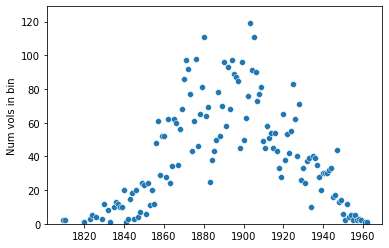

In [107]:
df = divide_range(data, 'birthyear', granularity = 1, 
                  degree = 0, minauthor_rule = False)
show_bin_floors(df)

And here's the smaller number of bins we create if we set a "floor" on the number of authors per bin. The change is mostly in the tails, and it's only relevant for birthyear and age.

86 bins.


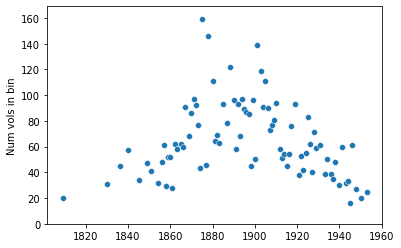

In [108]:
df = divide_range(data, 'birthyear', granularity = 1, 
                  degree = 0, minauthor_rule = True)
show_bin_floors(df)

13 bins.


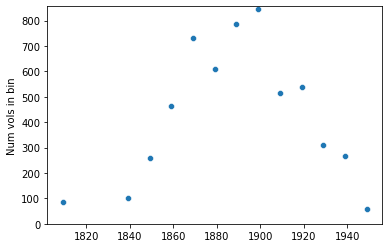

In [109]:
df = divide_range(data, 'birthyear', granularity = 10, 
                  degree = 0, minauthor_rule = True)
show_bin_floors(df)

In [105]:
# What the frame of dummy variables actually looks like

df.head()

,docid,author,l1809,l1839,l1849,l1859,l1869,l1879,l1889,l1899,l1909,l1919,l1929,l1939,l1949,l1963
0,uc1.32106005212219,"Petry, Ann Lane",0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,mdp.39015063937406,"Moore, John Trotwood",0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,uc1.$b100730,"Frank, Waldo David",0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,mdp.39015003629410,"Zelazny, Roger",0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,nyp.33433076053804,"Rinehart, Mary Roberts",0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Precomputing the bins

The function that computes binwidths and produces dummy variables is relatively slow, so there's some advantage to doing this in advance and then reusing the data frames.

In [36]:
degree0frames = dict()

granularity_options = [1, 2, 3, 4, 5, 7, 9, 11, 13, 15, 17, 21, 25, 29, 35, 40, 45, 50]

for pn in ['birthyear', 'firstpub', 'authorage']:
    degree0frames[pn] = dict()
    for span in granularity_options:
        df = divide_range(data, pn, granularity = span, degree = 0)
        degree0frames[pn][span] = df

If we wanted to use linear interpolation we could do that using degree 1.

In [41]:
degree1frames = dict()

granularity_options = [1, 2, 3, 4, 5, 7, 9, 11, 13, 17, 21, 30, 40, 50]

for pn in ['birthyear', 'firstpub', 'authorage']:
    degree1frames[pn] = dict()
    for span in granularity_options:
        df = divide_range(data, pn, granularity = span, degree = 1)
        degree1frames[pn][span] = df

### What sorts of fits can these bins produce?

We'll generally use "degree zero," which is effectively a step function. We could also adapt this approach to produce linear interpolation (or even cubic splines!) if we wanted, but I don't recommend it. More degrees of freedom are not what we need.

The cells below show the prediction produced when we model a given dependent variable (in this case "money" in LIWC) with a given dependent variable (in this case "birthyear") at a fixed binwidth/granularity.

We start with 1-year bins. A regression modeling "money" using birthyear will produce predictions that are just, basically, the average value of "money" for authors born in that year. (Except very early and late in the timeline, where a rule about 10-authors-per bin causes this to behave a bit like a step function.)

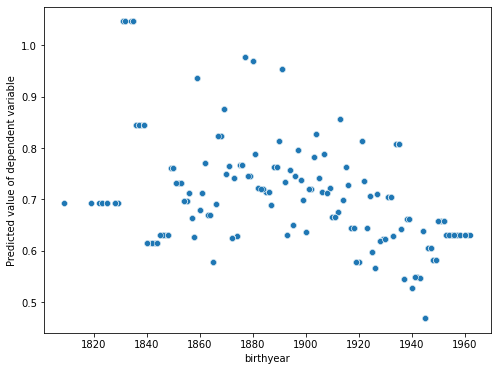

In [110]:
def showfit(framestouse, predictive_variable, topic, granularity):
    ''' Uses a set of bins specified by a frame to fit predictive_variable to a given
    topic, and then visualizes the predictions as a scatterplot against continuous values of the
    predictive variable.
    '''
    
    df = framestouse[predictive_variable][granularity]
    X = df.iloc[ : , 3 : ]
    y = data[topic].values
    reg = LinearRegression().fit(X, y)
    yhat = reg.predict(X)
    yhat[yhat < 0] = 0  # prediction cannot be below zero
    plt.figure(figsize = (8, 6))
    sns.scatterplot(x = data[predictive_variable], y = yhat)
    plt.ylabel('Predicted value of dependent variable')
    plt.show()

showfit(degree0frames, 'birthyear', 'money', 1)

Mostly there are different predictions for each year. Only at the tails of the distribution, where volumes are scarce, is there actual binning happening.

Compare this step function with 11-year granularity.

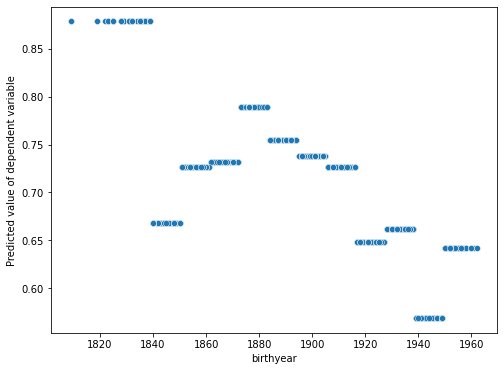

In [111]:
showfit(degree0frames, 'birthyear', 'money', 11)

We could also do linear interpolation if we wanted, using "degree 1." But I don't actually use this below.

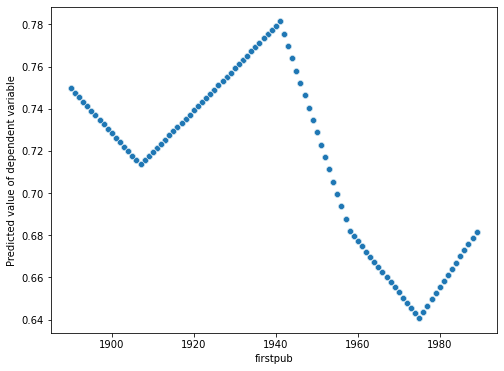

In [112]:
showfit(degree1frames, 'firstpub', 'money', 17)

In [101]:
# How linear interpolation works. We just change the dummy variables to have real values instead of 0 or 1.

degree1frames['birthyear'][17].head()

,docid,author,l1809,l1845,l1862,l1879,l1896,l1913,l1930,l1947,l1963
0,uc1.32106005212219,"Petry, Ann Lane",0.0,0.000000,0.000000,0.000000,0.294118,0.705882,0.000000,0.000000,0.0
1,mdp.39015063937406,"Moore, John Trotwood",0.0,0.235294,0.764706,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,uc1.$b100730,"Frank, Waldo David",0.0,0.000000,0.000000,0.411765,0.588235,0.000000,0.000000,0.000000,0.0
3,mdp.39015003629410,"Zelazny, Roger",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.588235,0.411765,0.0
4,nyp.33433076053804,"Rinehart, Mary Roberts",0.0,0.000000,0.176471,0.823529,0.000000,0.000000,0.000000,0.000000,0.0


### Cross-validate to find the granularity that produces best out-of-sample accuracy.

The cells immediately above show a regression fit to dummy variables with a fixed bin width.

The function below iterates through different granularity settings to find the best bin width for each predictive variable.

It does this with a five-fold cross-validation, so we are always predicting *out* of sample. Moreover, we stratify the dataset by author, so that we aren't overfitting the data by recognizing that particular authors tend to have a high or low level of a particular LIWC variable. We always test on unseen authors.

What level of granularity will produce the best result (lowest mean squared error) under these rigorous test conditions?

In [102]:
def make_predictors(data, dependentname, framestouse):
    
    predictornames = ['birthyear', 'firstpub', 'authorage']
    
    authors = list(set(data.hathi_author.tolist()))
    random.shuffle(authors)
    fivetestsets = np.array_split(authors, 5)
    
    newcolumns = dict()

    granularities = dict()
    
    meansquarederrors = dict()
    
    for pn in predictornames:        
        minimumerror = 900000000000000   # we initialize to a high value so any real result will be lower
        bestgran = 500                   # again unrealistically high
        
        granularity_options = list(framestouse[pn].keys())
        
        meansquarederrors[pn] = []
        bestcrossval = []
        
        for granularity in granularity_options:
            df = framestouse[pn][granularity].copy()
            df['newindex'] = data.index.copy()
            df.set_index('newindex', inplace = True)
            columnorder = [dependentname]
            columnorder.extend(df.columns.tolist())
            df[dependentname] = data[dependentname].values
            df = df.loc[ : , columnorder]
            
            error = 0
            crossvalidatedpredicts = pd.Series(dtype = 'float64')
            
            for testauths in fivetestsets:
                trainset = df.loc[~df.author.isin(testauths), : ]
                testset = df.loc[df.author.isin(testauths), : ]

                X = trainset.iloc[ : , 3 : ]
                y = trainset.iloc[ : , 0]

                reg = LinearRegression().fit(X, y)

                testX = testset.iloc[ : , 3 : ]
                testy = testset.iloc[ : , 0]

                yhat = reg.predict(testX)
                yhat[yhat < 0] = 0  # prediction cannot be below zero

                for actual, predicted in zip(testy, yhat):
                    error += (actual - predicted) ** 2
                
                crossvalidatedpredicts = pd.concat([crossvalidatedpredicts, pd.Series(yhat, index = testset.index)])
            
            if error < minimumerror:
                minimumerror = error
                bestgran = granularity
                bestcrossval = crossvalidatedpredicts
            
            meansquarederrors[pn].append((granularity, error / len(data)))

        granularities[pn] = bestgran
        
        newcolumns['yhat_based_on_' + pn] = bestcrossval
    
    newcolumns['yval'] = data[dependentname]
    
    return pd.DataFrame(newcolumns), granularities, meansquarederrors   

### What granularity turns out to be optimal?

Let's run a bunch of models and find out which granularity (bin width in years) produces the best cross-validated accuracy on unseen authors if we are, say, predicting the LIWC "money" variable.

In [59]:
predictdf, granularities, meansquarederrors = make_predictors(data, 'money', degree0frames)
print(granularities)

{'birthyear': 29, 'firstpub': 5, 'authorage': 17}


Wow, actually it turns out that a fairly coarse granularity is optimal here.

This is the best cross-validated fit to birthyear:

In [61]:
predictdf['birthyear'] = data.birthyear.values

<AxesSubplot:xlabel='birthyear', ylabel='yhat_based_on_birthyear'>

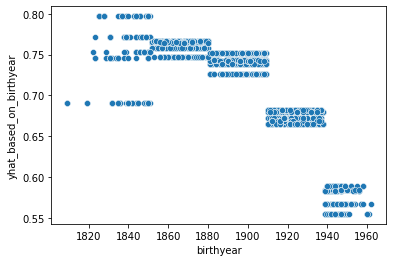

In [62]:
sns.scatterplot(data = predictdf, x = 'birthyear', y = 'yhat_based_on_birthyear')

Note that we have 29-year bins, and the predictions in each bin vary because of five-fold crossvalidation.

This is a realistically coarse model of the relation we can infer between birthyear and "money."

Why was that coarse model optimal?

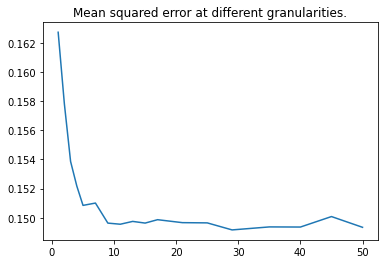

In [64]:
granular = [x[0] for x in meansquarederrors['birthyear']]
mse = [x[1] for x in meansquarederrors['birthyear']]
sns.lineplot(x = granular, y = mse)
plt.title('Mean squared error at different granularities.')
plt.show()

In this case the 29-year bin width produced lowest MSE out of sample, for "birthyear."

Here's the equivalent model for firstpub:

<AxesSubplot:xlabel='firstpub', ylabel='yhat_based_on_firstpub'>

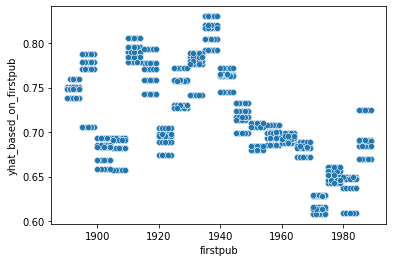

In [63]:
predictdf['firstpub'] = data.firstpub.values
sns.scatterplot(data = predictdf, x = 'firstpub', y = 'yhat_based_on_firstpub')

Notice that there's more vertical "uncertainty" in this model (more variation in the predictions). That's the tradeoff for the greater precision of the smaller (5-year) granularity.

The cross-validation process effectively tries to find an optimal fit, where there's as little error as possible.

And here's the error plot for different granularities in this case:

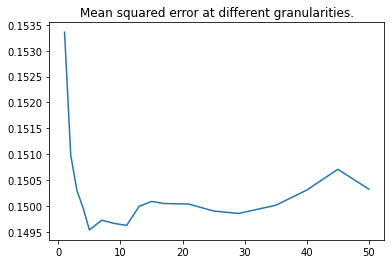

In [65]:
granular = [x[0] for x in meansquarederrors['firstpub']]
mse = [x[1] for x in meansquarederrors['firstpub']]
sns.lineplot(x = granular, y = mse)
plt.title('Mean squared error at different granularities.')
plt.show()

Even when a relatively fine-grained (5-year) model is preferable, as in the case of firstpub here, the error will always be much higher at 1-yr granularity. It's too easy to overfit to particular years where there happen to be books published/author births strongly associated with "money."

## First estimate of delta, degree 0, cross-validate to select best granularity

For each dependent variable, the code below optimizes predictions based on each of our three predictive variables.

Then it combines those predicted values in a linear regression, and we discover which of these (realistically uncertain) models of y is actually most useful in predicting real y.

In [80]:
resultframe = dict()
resultframe['LIWCcat'] = []
resultframe['birthyear'] = []
resultframe['firstpub'] = []
resultframe['age'] = []
resultframe['r2'] = []
resultframe['delta'] = []
resultframe['bygran'] = []
resultframe['fpgran'] = []
resultframe['agegran'] = []
totalerror = 0

for cat in data.columns.tolist()[9:]:
    predictdf, granularities, meansquarederrors = make_predictors(data, cat, degree0frames)
    X = predictdf.iloc[ : , 0:3]
    y = predictdf.iloc[ : , 3]
    
    # Pingouin linear regression on the three yhats, in order to
    # infer variable importance, which pingouin expresses by
    # partitioning r2 across predictors.
    
    lm = pg.linear_regression(X, y, relimp = True)
    lm.set_index('names', inplace = True)
    
    byweight = lm.loc['yhat_based_on_birthyear', 'relimp']
    resultframe['birthyear'].append(byweight)
    resultframe['LIWCcat'].append(cat)
    fpweight = lm.loc['yhat_based_on_firstpub', 'relimp']
    resultframe['firstpub'].append(fpweight)
    resultframe['age'].append(lm.loc['yhat_based_on_authorage', 'relimp'])
    resultframe['r2'].append(lm.loc['Intercept', 'r2'])
    resultframe['delta'].append(byweight / (byweight + fpweight))
    resultframe['bygran'].append(granularities['birthyear'])
    resultframe['fpgran'].append(granularities['firstpub'])
    resultframe['agegran'].append(granularities['authorage'])
    print(cat, granularities)
    print(round(byweight / (byweight + fpweight), 4), round(lm.loc['Intercept', 'r2'], 5))

Analytic {'birthyear': 40, 'firstpub': 45, 'authorage': 17}
0.6012 0.02058
Clout {'birthyear': 29, 'firstpub': 9, 'authorage': 45}
0.3228 0.01149
Authentic {'birthyear': 29, 'firstpub': 7, 'authorage': 13}
0.3954 0.02063
Tone {'birthyear': 11, 'firstpub': 9, 'authorage': 4}
0.6229 0.13425
WPS {'birthyear': 9, 'firstpub': 40, 'authorage': 40}
0.8148 0.00487
Sixltr {'birthyear': 35, 'firstpub': 11, 'authorage': 21}
0.2362 0.01624
Dic {'birthyear': 21, 'firstpub': 13, 'authorage': 35}
0.2875 0.02209
function {'birthyear': 50, 'firstpub': 25, 'authorage': 13}
0.249 0.00952
pronoun {'birthyear': 45, 'firstpub': 25, 'authorage': 45}
0.2234 0.0058
ppron {'birthyear': 50, 'firstpub': 25, 'authorage': 45}
0.0968 0.004
i {'birthyear': 17, 'firstpub': 9, 'authorage': 50}
0.5109 0.03749
we {'birthyear': 11, 'firstpub': 15, 'authorage': 21}
0.4344 0.01354
you {'birthyear': 29, 'firstpub': 40, 'authorage': 35}
0.987 0.00459
shehe {'birthyear': 29, 'firstpub': 25, 'authorage': 50}
0.0917 0.01536
they

### Exploring the results

Overall r2 is fairly low, but it can be much higher for some topics.

In [81]:
result = pd.DataFrame(resultframe)
np.mean(result.r2)

0.04176257002850373

<AxesSubplot:xlabel='r2'>

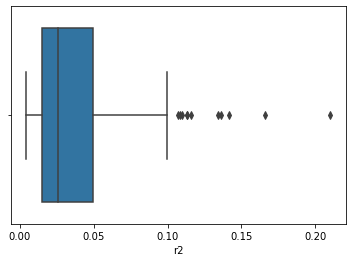

In [85]:
sns.boxplot(x = result.r2)

In [113]:
result.head()

,LIWCcat,birthyear,firstpub,age,r2,delta,bygran,fpgran,agegran
0,Analytic,0.001134,0.000752,0.018696,0.020583,0.601224,40,45,17
1,Clout,0.003700,0.007762,0.000031,0.011493,0.322836,29,9,45
2,Authentic,0.008087,0.012366,0.000178,0.020631,0.395405,29,7,13
3,Tone,0.070877,0.042912,0.020463,0.134252,0.622883,11,9,4
4,WPS,0.003934,0.000894,0.000040,0.004869,0.814796,9,40,40


In [114]:
result.to_csv('LIWCregressionresult1.tsv', sep = '\t', index = False)

## Overall estimate of delta

The crudest way to estimate delta is just to average across all categories.

In [82]:
np.mean(result.delta)

0.49750002884755773

<AxesSubplot:xlabel='delta'>

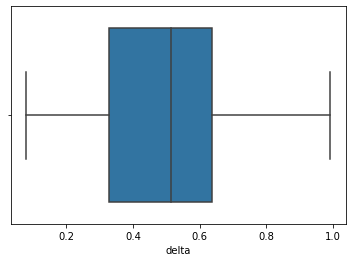

In [86]:
sns.boxplot(x = result.delta)

#### a better estimate

The way I'm proposing we do this instead is to add up the partitioned r2s for all categories and then check the ratio. This way topics that are well explained contribute more to the result than topics where r2 is actually tiny.

In [83]:
np.sum(result.birthyear) / (np.sum(result.birthyear) + np.sum(result.firstpub))

0.5370009841945144

Either way you look at it, the overall answer for LIWC is that roughly half of the change over time is attributable to cohort effects.

## What happens if we don't cross-validate?

Let's try this without cross-validation, and with the granularity fixed at two-year intervals.

We get very different results!

In [87]:
def regression_fixed_granularity(data, dependentname, framestouse, granularity):
    predictornames = ['birthyear', 'firstpub', 'authorage']
    newcolumns = dict()
    for pn in predictornames:  
                                 
        df = framestouse[pn][granularity].copy()
        columnorder = [dependentname]
        columnorder.extend(df.columns.tolist())
        df[dependentname] = data[dependentname].values
        df = df.loc[ : , columnorder]
        X = df.iloc[ : , 3 : ]
        y = df.iloc[ : , 0]
        reg = LinearRegression().fit(X, y)
        yhat = reg.predict(X)
        yhat[yhat < 0] = 0  # prediction cannot be below zero
        newcolumns['yhat_based_on_' + pn] = yhat
    
    return pd.DataFrame(newcolumns)

In [91]:
crudeframe = dict()
crudeframe['LIWCcat'] = []
crudeframe['birthyear'] = []
crudeframe['firstpub'] = []
crudeframe['age'] = []
crudeframe['r2'] = []
crudeframe['delta'] = []
totalerror = 0

for cat in data.columns.tolist()[9:]:
    predictdf = regression_fixed_granularity(data, cat, degree0frames, 2)
    X = predictdf
    y = data[cat]
    
    # Pingouin linear regression on the three yhats, in order to
    # infer variable importance, which pingouin expresses by
    # partitioning r2 across predictors.
    
    lm = pg.linear_regression(X, y, relimp = True)
    lm.set_index('names', inplace = True)
    
    byweight = lm.loc['yhat_based_on_birthyear', 'relimp']
    crudeframe['birthyear'].append(byweight)
    crudeframe['LIWCcat'].append(cat)
    fpweight = lm.loc['yhat_based_on_firstpub', 'relimp']
    crudeframe['firstpub'].append(fpweight)
    crudeframe['age'].append(lm.loc['yhat_based_on_authorage', 'relimp'])
    crudeframe['r2'].append(lm.loc['Intercept', 'r2'])
    crudeframe['delta'].append(byweight / (byweight + fpweight))
    print(cat, granularities)
    print(round(byweight / (byweight + fpweight), 4), round(lm.loc['Intercept', 'r2'], 5))

Analytic {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.7441 0.07379
Clout {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.663 0.06097
Authentic {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.596 0.05798
Tone {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6679 0.17776
WPS {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.7542 0.03944
Sixltr {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6836 0.07645
Dic {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6902 0.07791
function {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6893 0.06212
pronoun {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.7241 0.05371
ppron {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.7294 0.0572
i {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.5915 0.0769
we {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6187 0.04963
you {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.8828 0.06677
shehe {'birthyear': 21, 'firstpub': 13, 'authorage': 25}
0.6427 0.064

In [93]:
cruderesult = pd.DataFrame(crudeframe)
np.mean(cruderesult.r2)

0.08974379711192197

Wow, a much higher r2. (Because it can overfit to authors.)

In [95]:
np.mean(cruderesult.delta)

0.6992136933488722

And a much, much higher estimate of delta. (Because it can overfit to authors, and definitely will, with a 2-year interval.)

In [100]:
# How many authors we have

len(set(data.hathi_author))

1198